In [29]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline
from PIL import Image
from keras.callbacks import EarlyStopping

from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Reshape, Permute, Lambda
from keras.activations import softmax
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import np_utils

### Load image data

In [30]:
im_full_stack = io.imread('unet_train.tif') # test dataset

# swap the dimentions for keras, so the channels are in the end
im_full_stack = np.moveaxis(im_full_stack, 0, 2)

### Visualize images

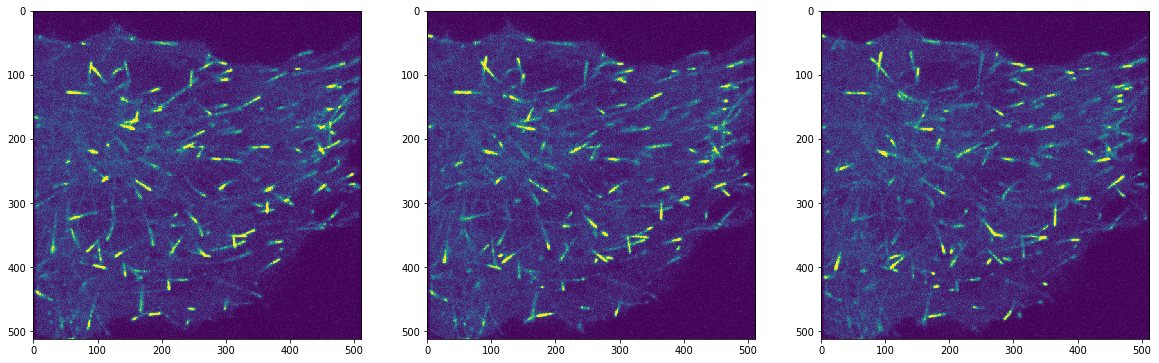

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.imshow(im_full_stack[:,:,0])
ax2.imshow(im_full_stack[:,:,1])
ax3.imshow(im_full_stack[:,:,2])
print()

### Custom defined loss

In [32]:
def weighted_matrix_loss(y_true, y_pred):
    # in y_true, (None, dimsx, dimsy, 4 channels where three first one are 1-hot-veector for the class and the next one is the weight)
    y_pred_c = K.clip(y_pred, K.epsilon(), 1)
    
    elms = y_true[:,:,:,:3] * K.log(y_pred_c) 
    elms = K.sum(elms, 3) * y_true[:,:,:,3] 
    loss  = -K.mean(elms, (0,1,2))

    return loss

### Unet

In [35]:
n_classes = 3

inputs = Input((patch_size, patch_size, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate= 2)(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate = 2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print(conv1.shape)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print(conv2.shape)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print(conv3.shape)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
print(conv4.shape)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv11 = Conv2D(n_classes, (1, 1), activation='linear')(conv10)
#print(conv10.shape)

out = Lambda(lambda x: softmax(x, axis = 3))(conv11)

model = Model(inputs=[inputs], outputs=[out])

model.compile(optimizer = 'adam', loss = weighted_matrix_loss, metrics=['accuracy'])

(?, 64, 64, 32)
(?, 32, 32, 64)
(?, 16, 16, 128)
(?, 8, 8, 256)
(?, 4, 4, 512)


### apply prediction to the image by patching the whole thing

In [36]:
model.load_weights('weights.h5')

im_size = im_full_stack.shape[0]

def predict_one_image(test_image, im_size, patch_size = 64):
    # patch the image for the classification 
    test_patches = []
    nn = im_size // patch_size
    for j in range(nn):
        for i in range(nn):
            test_patches.append(test_image[i*patch_size:(i+1) * patch_size, j*patch_size:(j + 1)*patch_size] / 255)

    test_patches = np.array(test_patches)
    test_patches_res = model.predict(test_patches)
    test_patches_res = test_patches_res[:,:,:,2]

    test_image_res = np.empty(test_image.shape).astype(np.float)
    for j in range(nn):
        for i in range(nn):
            test_image_res[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size, 0] = test_patches_res[i+j*nn]
    
    return test_image_res




from skimage import external

for i in range(im_full_stack.shape[2]):
    res = predict_one_image(im_full_stack[:,:,i:i+1], im_size)
    im = (res[:,:,0]*255).astype(np.uint8)
    external.tifffile.imsave('./results/unet_%s.tif' % (i+1), im)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
#ax1.imshow(test_image[:,:,0])
#ax2.imshow(res[:,:,0])
#print()